# Reward competition distance from port analysis

Brief 1-2 sentence description of notebook.

In [24]:
import glob
from datetime import datetime
from functools import reduce


In [81]:
# Imports of all used packages and libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from scipy.interpolate import interp1d

## Inputs & Data

Explanation of each input and where it comes from.

In [109]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case
OUTPUT_DIR = "./proc" # where data is saved should always be shown in the inputs
# ITIs from MED-PC code
FRAME_RATE = 30
ALL_ITIS = [80, 90, 80, 75, 100, 95, 90, 80, 90, 100, 90, 120, 90, 85, 90, 95, 120, 80, 95, 80, 90, 80, 75, 100, 95, 90, 80, 90, 100, 90, 120, 90, 85, 90, 95, 90, 80, 90, 100, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90 ]
# Converting the seconds into frames
ALL_ITIS = [num * FRAME_RATE for num in ALL_ITIS]
MEDPC_BOX_WIDTH = 29.5
MEDPC_BOX_LENGTH = 24
FRAME_RANGE = 20 * FRAME_RATE

In [4]:
TONE_START_DF = pd.read_excel("./data/reward_comp_tone_sleap_frames.xlsx")

## Outputs

Describe each output that the notebook creates. 

- Is it a plot or is it data?

- How valuable is the output and why is it valuable or useful?

## Functions

In [5]:
# As much code and as many cells as required
# includes EDA and playing with data
# GO HAM!

# Ideally functions are defined here first and then data is processed using the functions

# function names are short and in snake case all lowercase
# a function name should be unique but does not have to describe the function
# doc strings describe functions not function names



In [6]:

def get_running_total(lst: list) -> list:
    """
    Compute the running total for a list of numbers.
    
    Given a list of numbers, this function returns a new list 
    where each element is the cumulative sum of the elements 
    up to that point in the original list.

    Parameters:
    - lst (list): A list of numbers.

    Returns:
    - list: A list containing the running total.

    Example:
    >>> get_running_total([1, 2, 3, 4])
    [1, 3, 6, 10]
    """

    def accumulator(acc, x):
        if acc:
            return acc + [acc[-1] + x]
        else:
            return [x]
        
    return reduce(accumulator, lst, [])

In [41]:

def extract_sleap_data_from_h5(filename: str) -> tuple:
    """
    Extract relevant SLEAP data from an h5 file.

    Given a filename for an h5 file, this function retrieves:
    - locations of the tracks,
    - names of the nodes,
    - names of the tracks.

    Parameters:
    - filename (str): The path to the h5 file.

    Returns:
    - tuple: A tuple containing:
      * locations (numpy.ndarray): Array of track locations.
      * node_names (list[str]): List of node names.
      * track_names (list[str]): List of track names.

    Example:
    >>> locations, node_names, track_names = extract_sleap_data_from_h5("path/to/file.h5")
    """

    with h5py.File(filename, "r") as f:
        locations = f["tracks"][:].T
        node_names = [n.decode() for n in f["node_names"][:]]
        track_names = [n.decode() for n in f["track_names"][:]]
    
    return locations, node_names, track_names

In [80]:
def interpolate_missing_coords(data: np.ndarray, method: str = "linear") -> np.ndarray:
    """
    Interpolate missing values in the provided multi-dimensional data.

    This function is designed to handle data where the first dimension represents different data points,
    and the remaining dimensions (flattened) represent different features. Interpolation is applied to each feature
    independently to fill missing values.

    Parameters:
    - data (np.ndarray): The input data with potential missing values.
    - method (str, optional): The interpolation method to be used. Default is 'linear'.

    Returns:
    - np.ndarray: The data with missing values interpolated.

    Example:
    >>> filled_data = interpolate_missing_coords(np.array([[1, np.nan, 3], [4, 5, 6]]))
    """

    # Store initial shape for later reshaping.
    initial_shape = data.shape

    # Reshape data: flatten dimensions beyond the first one.
    data = data.reshape((initial_shape[0], -1))

    # Interpolate along each column (which represents a flattened dimension of the original data).
    for i in range(data.shape[-1]):
        column_data = data[:, i]

        # Indices of valid (non-NaN) data points.
        valid_indices = np.flatnonzero(~np.isnan(column_data))

        # Build the interpolant function.
        interpolant = interp1d(valid_indices, 
                               column_data[valid_indices], 
                               kind=method, 
                               fill_value=np.nan, 
                               bounds_error=False)

        # Indices of missing (NaN) data points.
        missing_indices = np.flatnonzero(np.isnan(column_data))

        # Fill missing values using the interpolant.
        column_data[missing_indices] = interpolant(missing_indices)

        # Handle any remaining NaNs due to them being outside the valid range.
        nan_mask = np.isnan(column_data)
        column_data[nan_mask] = np.interp(np.flatnonzero(nan_mask), 
                                          valid_indices, 
                                          column_data[valid_indices])

        # Save the updated column data back.
        data[:, i] = column_data

    # Restore original data shape.
    data = data.reshape(initial_shape)

    return data

In [97]:
def scale_sleap_coordinates(row, 
                            coord_col: str, 
                            height_ratio_col: str = "height_ratio", 
                            width_ratio_col: str = "width_ratio") -> np.ndarray:
    """
    Scale SLEAP track coordinates based on provided height and width ratios.

    This function scales the x-coordinates using the width ratio and the y-coordinates using the height ratio.

    Parameters:
    - row (pd.Series): A row from a pandas DataFrame containing SLEAP track data and scaling ratios.
    - coord_col (str): The column name containing the track coordinates.
    - height_ratio_col (str, optional): The column name containing the height scaling ratio. Default is "height_ratio".
    - width_ratio_col (str, optional): The column name containing the width scaling ratio. Default is "width_ratio".

    Returns:
    - np.ndarray: The scaled coordinates.
    """

    x_coords_scaled = row[coord_col][:,:,0] * row[width_ratio_col]
    y_coords_scaled = row[coord_col][:,:,1] * row[height_ratio_col]

    return np.dstack((x_coords_scaled, y_coords_scaled))

## Processing

Describe what is done to the data here and how inputs are manipulated to generate outputs. 

- Getting the file name as opposed to the whole path

In [7]:
TONE_START_DF.head()

,File Name,Frame Start,FPS,Strain
0,10-03-22_Test_1_1-1v1-2,2135,30,C57
1,10-03-22_Test_2_1-3v1-4,2123,29,C57
2,10-03-22_Test_3_2-1v2-2,2125,29,C57
3,10-03-22_Test_13_2-2v2-4,2138,30,C57
4,10-03-22_Test_14_2-1v2-3,2127,29,C57


- Removing "fixed" as part of the file name

In [8]:
TONE_START_DF["file_base"] = TONE_START_DF["File Name"].apply(lambda x: x.split(".")[0])

- Getting the date based on the file base

In [9]:
TONE_START_DF["date"] = TONE_START_DF["file_base"].apply(lambda x: datetime.strptime(x.split("_")[0].strip(""), '%m-%d-%y').strftime('%Y-%m-%d'))



In [10]:
TONE_START_DF.head()

,File Name,Frame Start,FPS,Strain,file_base,date
0,10-03-22_Test_1_1-1v1-2,2135,30,C57,10-03-22_Test_1_1-1v1-2,2022-10-03
1,10-03-22_Test_2_1-3v1-4,2123,29,C57,10-03-22_Test_2_1-3v1-4,2022-10-03
2,10-03-22_Test_3_2-1v2-2,2125,29,C57,10-03-22_Test_3_2-1v2-2,2022-10-03
3,10-03-22_Test_13_2-2v2-4,2138,30,C57,10-03-22_Test_13_2-2v2-4,2022-10-03
4,10-03-22_Test_14_2-1v2-3,2127,29,C57,10-03-22_Test_14_2-1v2-3,2022-10-03


- Getting the subject name from the file name

In [11]:
TONE_START_DF["all_subj"] = TONE_START_DF["file_base"].apply(lambda x: sorted(x.split("_")[-1].split(".")[0].split("v")))

- Replacing the hyphen with a period so that we have a shared ID across datasets

In [12]:
TONE_START_DF["all_subj"] = TONE_START_DF["all_subj"].apply(lambda x: tuple([subj.replace("-", ".").strip() for subj in x]))

In [13]:
TONE_START_DF.head()

,File Name,Frame Start,FPS,Strain,file_base,date,all_subj
0,10-03-22_Test_1_1-1v1-2,2135,30,C57,10-03-22_Test_1_1-1v1-2,2022-10-03,"(1.1, 1.2)"
1,10-03-22_Test_2_1-3v1-4,2123,29,C57,10-03-22_Test_2_1-3v1-4,2022-10-03,"(1.3, 1.4)"
2,10-03-22_Test_3_2-1v2-2,2125,29,C57,10-03-22_Test_3_2-1v2-2,2022-10-03,"(2.1, 2.2)"
3,10-03-22_Test_13_2-2v2-4,2138,30,C57,10-03-22_Test_13_2-2v2-4,2022-10-03,"(2.2, 2.4)"
4,10-03-22_Test_14_2-1v2-3,2127,29,C57,10-03-22_Test_14_2-1v2-3,2022-10-03,"(2.1, 2.3)"


- Making separate rows for each subject

In [14]:
TONE_START_DF["subj_id"] = TONE_START_DF["all_subj"]

In [15]:
TONE_START_DF = TONE_START_DF.explode(column="subj_id")

In [16]:
TONE_START_DF.head()

,File Name,Frame Start,FPS,Strain,file_base,date,all_subj,subj_id
0,10-03-22_Test_1_1-1v1-2,2135,30,C57,10-03-22_Test_1_1-1v1-2,2022-10-03,"(1.1, 1.2)",1.1
0,10-03-22_Test_1_1-1v1-2,2135,30,C57,10-03-22_Test_1_1-1v1-2,2022-10-03,"(1.1, 1.2)",1.2
1,10-03-22_Test_2_1-3v1-4,2123,29,C57,10-03-22_Test_2_1-3v1-4,2022-10-03,"(1.3, 1.4)",1.3
1,10-03-22_Test_2_1-3v1-4,2123,29,C57,10-03-22_Test_2_1-3v1-4,2022-10-03,"(1.3, 1.4)",1.4
2,10-03-22_Test_3_2-1v2-2,2125,29,C57,10-03-22_Test_3_2-1v2-2,2022-10-03,"(2.1, 2.2)",2.1


- Getting the index of the subject from the tuple of both subjects

In [17]:
TONE_START_DF["subj_index"] = TONE_START_DF.apply(lambda x: list(x["all_subj"]).index(x["subj_id"]), axis=1)

In [18]:
TONE_START_DF.head()

,File Name,Frame Start,FPS,Strain,file_base,date,all_subj,subj_id,subj_index
0,10-03-22_Test_1_1-1v1-2,2135,30,C57,10-03-22_Test_1_1-1v1-2,2022-10-03,"(1.1, 1.2)",1.1,0
0,10-03-22_Test_1_1-1v1-2,2135,30,C57,10-03-22_Test_1_1-1v1-2,2022-10-03,"(1.1, 1.2)",1.2,1
1,10-03-22_Test_2_1-3v1-4,2123,29,C57,10-03-22_Test_2_1-3v1-4,2022-10-03,"(1.3, 1.4)",1.3,0
1,10-03-22_Test_2_1-3v1-4,2123,29,C57,10-03-22_Test_2_1-3v1-4,2022-10-03,"(1.3, 1.4)",1.4,1
2,10-03-22_Test_3_2-1v2-2,2125,29,C57,10-03-22_Test_3_2-1v2-2,2022-10-03,"(2.1, 2.2)",2.1,0


- Dropping all rows that don't have numbers for frame start

In [19]:
TONE_START_DF = TONE_START_DF[TONE_START_DF["Frame Start"].astype(str).str.isnumeric()]

In [20]:
TONE_START_DF["Frame Start"] = TONE_START_DF["Frame Start"].astype(int)

In [21]:
TONE_START_DF["all_tone_frame"] = TONE_START_DF.apply(lambda row: get_running_total([row["Frame Start"]] + ALL_ITIS), axis=1)

In [38]:
TONE_START_DF.head()

,File Name,Frame Start,FPS,Strain,file_base,date,all_subj,subj_id,subj_index,all_tone_frame
0,10-03-22_Test_1_1-1v1-2,2135,30,C57,10-03-22_Test_1_1-1v1-2,2022-10-03,"(1.1, 1.2)",1.1,0,"[2135, 4535, 7235, 9635, 11885, 14885, 17735, ..."
0,10-03-22_Test_1_1-1v1-2,2135,30,C57,10-03-22_Test_1_1-1v1-2,2022-10-03,"(1.1, 1.2)",1.2,1,"[2135, 4535, 7235, 9635, 11885, 14885, 17735, ..."
1,10-03-22_Test_2_1-3v1-4,2123,29,C57,10-03-22_Test_2_1-3v1-4,2022-10-03,"(1.3, 1.4)",1.3,0,"[2123, 4523, 7223, 9623, 11873, 14873, 17723, ..."
1,10-03-22_Test_2_1-3v1-4,2123,29,C57,10-03-22_Test_2_1-3v1-4,2022-10-03,"(1.3, 1.4)",1.4,1,"[2123, 4523, 7223, 9623, 11873, 14873, 17723, ..."
2,10-03-22_Test_3_2-1v2-2,2125,29,C57,10-03-22_Test_3_2-1v2-2,2022-10-03,"(2.1, 2.2)",2.1,0,"[2125, 4525, 7225, 9625, 11875, 14875, 17725, ..."


# Get Coordinates of all the corners

- Reading in all the files with the corner coordinate and the pose tracking"

In [25]:
all_corner_h5 = glob.glob("./data/corner_labeling/*.corner.h5")

In [26]:
all_pose_estimation_h5 = glob.glob("./data/sleap_pose_tracking/*.h5")

In [32]:
all_corner_h5[:5]

['./data/corner_labeling/10-04-22_Test_21_1-1v1-3.fixed.corner.h5',
 './data/corner_labeling/10-03-22_Test_15_1-2v1-4.fixed.corner.h5',
 './data/corner_labeling/10-04-22_Test_19_4-1v4-3.fixed.corner.h5',
 './data/corner_labeling/10-04-22_Test_15_6-1v6-3.fixed.corner.h5',
 './data/corner_labeling/10-04-22_Test_11_1-1v1-4.fixed.corner.h5']

In [33]:
all_pose_estimation_h5[:5]

['./data/sleap_pose_tracking/10-03-22_Test_7_4-1v4-2.fixed.analysis.h5',
 './data/sleap_pose_tracking/10-04-22_Test_8_3-2v3-3.fixed.analysis.h5',
 './data/sleap_pose_tracking/10-03-22_Test_8_4-3v4-4.fixed.analysis.h5',
 './data/sleap_pose_tracking/10-03-22_Test_19_3-2v3-4.fixed.analysis.h5',
 './data/sleap_pose_tracking/10-04-22_Test_16_6-2v6-4.fixed.analysis.h5']

In [27]:
len(all_corner_h5)

33

In [28]:
len(all_pose_estimation_h5)

33

- Matching all the video file names to the corresponding corner and pose tracking coordinate file

In [29]:
file_name_to_corner = {item.split("/")[-1].split(".")[0].strip(): item for item in all_corner_h5}

In [30]:
file_name_to_pose_estimation = {item.split("/")[-1].split(".")[0].strip(): item for item in all_pose_estimation_h5}

In [36]:
file_name_to_corner[list(file_name_to_corner.keys())[0]]

'./data/corner_labeling/10-04-22_Test_21_1-1v1-3.fixed.corner.h5'

In [50]:
TONE_START_DF["corner_file"] = TONE_START_DF["file_base"].map(file_name_to_corner)
TONE_START_DF["pose_estimation_file"] = TONE_START_DF["file_base"].map(file_name_to_pose_estimation)

In [51]:
TONE_START_DF.head()

,File Name,Frame Start,FPS,Strain,file_base,date,all_subj,subj_id,subj_index,all_tone_frame,corner_file,pose_estimation_file
0,10-03-22_Test_1_1-1v1-2,2135,30,C57,10-03-22_Test_1_1-1v1-2,2022-10-03,"(1.1, 1.2)",1.1,0,"[2135, 4535, 7235, 9635, 11885, 14885, 17735, ...",./data/corner_labeling/10-03-22_Test_1_1-1v1-2...,./data/sleap_pose_tracking/10-03-22_Test_1_1-1...
0,10-03-22_Test_1_1-1v1-2,2135,30,C57,10-03-22_Test_1_1-1v1-2,2022-10-03,"(1.1, 1.2)",1.2,1,"[2135, 4535, 7235, 9635, 11885, 14885, 17735, ...",./data/corner_labeling/10-03-22_Test_1_1-1v1-2...,./data/sleap_pose_tracking/10-03-22_Test_1_1-1...
1,10-03-22_Test_2_1-3v1-4,2123,29,C57,10-03-22_Test_2_1-3v1-4,2022-10-03,"(1.3, 1.4)",1.3,0,"[2123, 4523, 7223, 9623, 11873, 14873, 17723, ...",./data/corner_labeling/10-03-22_Test_2_1-3v1-4...,./data/sleap_pose_tracking/10-03-22_Test_2_1-3...
1,10-03-22_Test_2_1-3v1-4,2123,29,C57,10-03-22_Test_2_1-3v1-4,2022-10-03,"(1.3, 1.4)",1.4,1,"[2123, 4523, 7223, 9623, 11873, 14873, 17723, ...",./data/corner_labeling/10-03-22_Test_2_1-3v1-4...,./data/sleap_pose_tracking/10-03-22_Test_2_1-3...
2,10-03-22_Test_3_2-1v2-2,2125,29,C57,10-03-22_Test_3_2-1v2-2,2022-10-03,"(2.1, 2.2)",2.1,0,"[2125, 4525, 7225, 9625, 11875, 14875, 17725, ...",./data/corner_labeling/10-03-22_Test_3_2-1v2-2...,./data/sleap_pose_tracking/10-03-22_Test_3_2-1...


- Function that gets the SLEAP data

In [52]:
corner_node_names = extract_sleap_data_from_h5(all_corner_h5[0])[1]

In [53]:
corner_node_names

['box_bottom_left',
 'reward_port',
 'box_bottom_right',
 'box_top_left',
 'box_top_right']

- Getting the coordinates of each corner and the reward port

In [55]:
TONE_START_DF["corner_sleap"] = TONE_START_DF["corner_file"].apply(lambda x: extract_sleap_data_from_h5(x))

In [61]:
for index, node in enumerate(corner_node_names):
    TONE_START_DF["{}_coordinates".format(node)] = TONE_START_DF["corner_file"].apply(lambda x: extract_sleap_data_from_h5(x)[0][0,index,:,0])

In [63]:
TONE_START_DF.head()

,File Name,Frame Start,FPS,Strain,file_base,date,all_subj,subj_id,subj_index,all_tone_frame,corner_file,pose_estimation_file,corner_sleap,corner_names,box_bottom_left_coordinates,reward_port_coordinates,box_bottom_right_coordinates,box_top_left_coordinates,box_top_right_coordinates
0,10-03-22_Test_1_1-1v1-2,2135,30,C57,10-03-22_Test_1_1-1v1-2,2022-10-03,"(1.1, 1.2)",1.1,0,"[2135, 4535, 7235, 9635, 11885, 14885, 17735, ...",./data/corner_labeling/10-03-22_Test_1_1-1v1-2...,./data/sleap_pose_tracking/10-03-22_Test_1_1-1...,"([[[[390.9854761 ]\n [550.10455014]], [[513.88...","[box_bottom_left, reward_port, box_bottom_righ...","[390.9854761048566, 550.1045501415538]","[513.8875473467701, 571.6172631900606]","[638.3064796862376, 555.5861352215592]","[408.330015339179, 256.61728326956387]","[644.898096304591, 260.851923832358]"
0,10-03-22_Test_1_1-1v1-2,2135,30,C57,10-03-22_Test_1_1-1v1-2,2022-10-03,"(1.1, 1.2)",1.2,1,"[2135, 4535, 7235, 9635, 11885, 14885, 17735, ...",./data/corner_labeling/10-03-22_Test_1_1-1v1-2...,./data/sleap_pose_tracking/10-03-22_Test_1_1-1...,"([[[[390.9854761 ]\n [550.10455014]], [[513.88...","[box_bottom_left, reward_port, box_bottom_righ...","[390.9854761048566, 550.1045501415538]","[513.8875473467701, 571.6172631900606]","[638.3064796862376, 555.5861352215592]","[408.330015339179, 256.61728326956387]","[644.898096304591, 260.851923832358]"
1,10-03-22_Test_2_1-3v1-4,2123,29,C57,10-03-22_Test_2_1-3v1-4,2022-10-03,"(1.3, 1.4)",1.3,0,"[2123, 4523, 7223, 9623, 11873, 14873, 17723, ...",./data/corner_labeling/10-03-22_Test_2_1-3v1-4...,./data/sleap_pose_tracking/10-03-22_Test_2_1-3...,"([[[[351.04978404]\n [626.27280513]], [[519.57...","[box_bottom_left, reward_port, box_bottom_righ...","[351.0497840352974, 626.2728051332355]","[519.576353919354, 659.5076696013427]","[693.7994220451658, 629.0949247066953]","[352.9002955462512, 212.30683090705492]","[694.5621623710648, 212.07868790475084]"
1,10-03-22_Test_2_1-3v1-4,2123,29,C57,10-03-22_Test_2_1-3v1-4,2022-10-03,"(1.3, 1.4)",1.4,1,"[2123, 4523, 7223, 9623, 11873, 14873, 17723, ...",./data/corner_labeling/10-03-22_Test_2_1-3v1-4...,./data/sleap_pose_tracking/10-03-22_Test_2_1-3...,"([[[[351.04978404]\n [626.27280513]], [[519.57...","[box_bottom_left, reward_port, box_bottom_righ...","[351.0497840352974, 626.2728051332355]","[519.576353919354, 659.5076696013427]","[693.7994220451658, 629.0949247066953]","[352.9002955462512, 212.30683090705492]","[694.5621623710648, 212.07868790475084]"
2,10-03-22_Test_3_2-1v2-2,2125,29,C57,10-03-22_Test_3_2-1v2-2,2022-10-03,"(2.1, 2.2)",2.1,0,"[2125, 4525, 7225, 9625, 11875, 14875, 17725, ...",./data/corner_labeling/10-03-22_Test_3_2-1v2-2...,./data/sleap_pose_tracking/10-03-22_Test_3_2-1...,"([[[[336.35679625]\n [588.63682422]], [[508.91...","[box_bottom_left, reward_port, box_bottom_righ...","[336.35679625338616, 588.6368242233518]","[508.9149672788628, 621.5982963374584]","[680.1398630208826, 585.5933059960898]","[343.6821422185993, 166.10302351623739]","[675.7125022249096, 169.20404824713103]"


- Plotting the coordinates of the corners to verify

In [65]:
corner_columns = [col for col in TONE_START_DF.columns if "coordinates" in col]

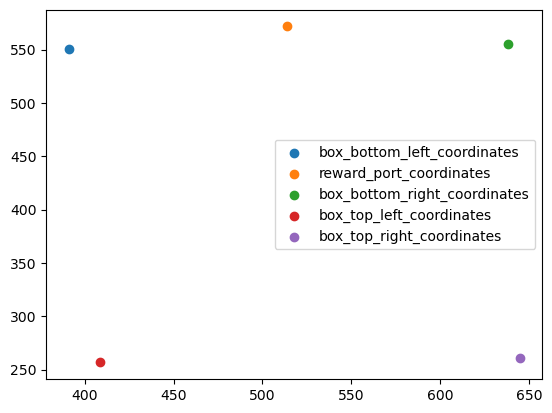

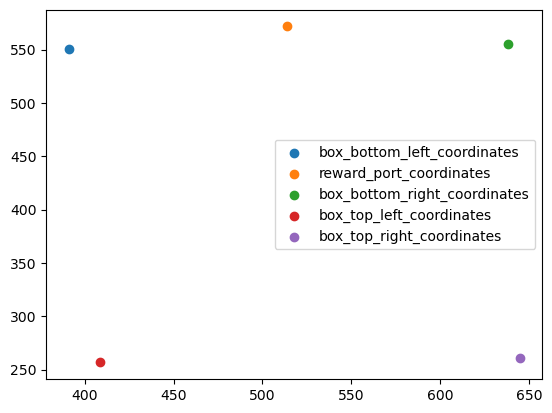

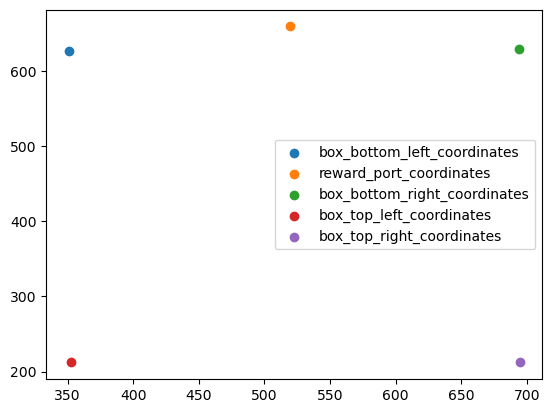

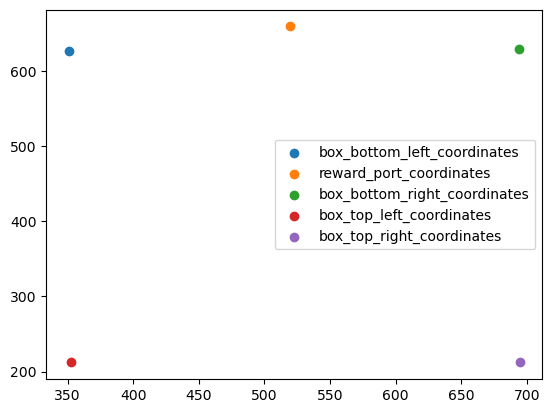

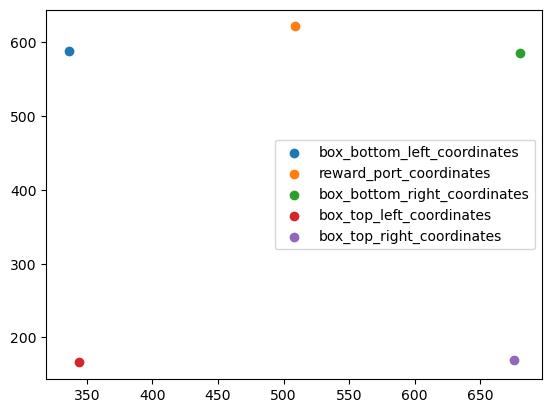

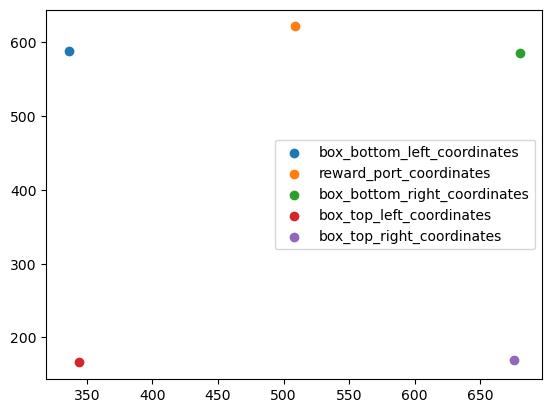

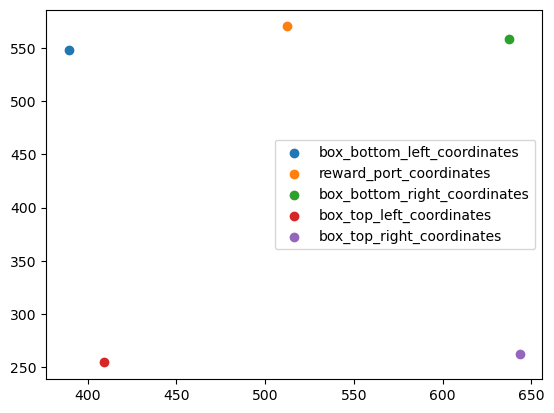

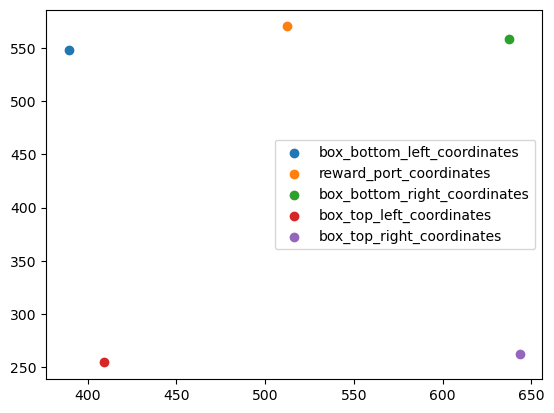

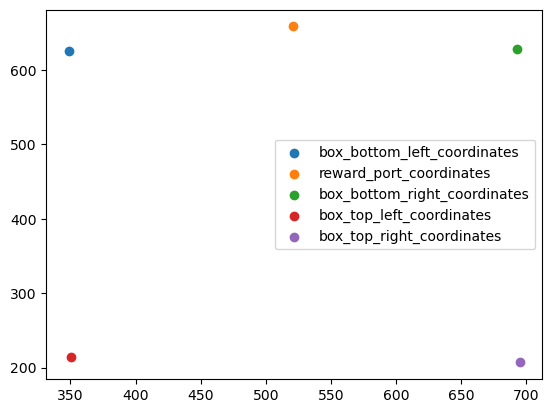

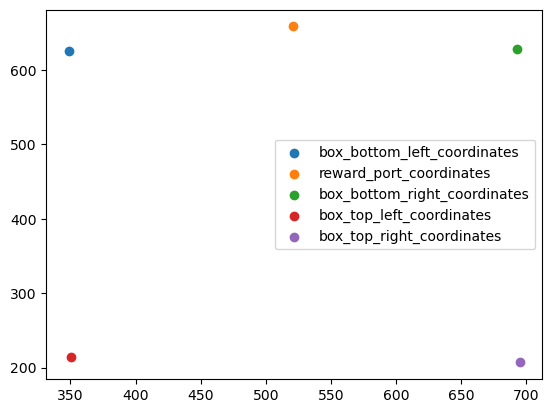

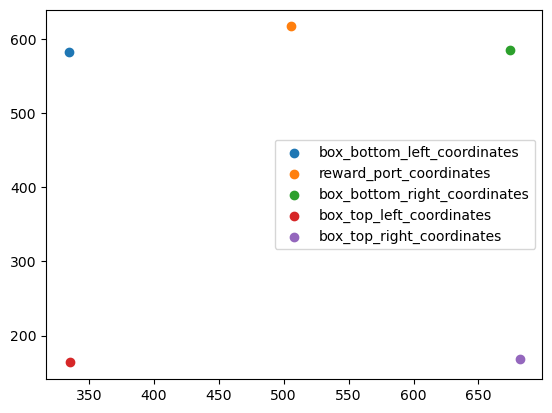

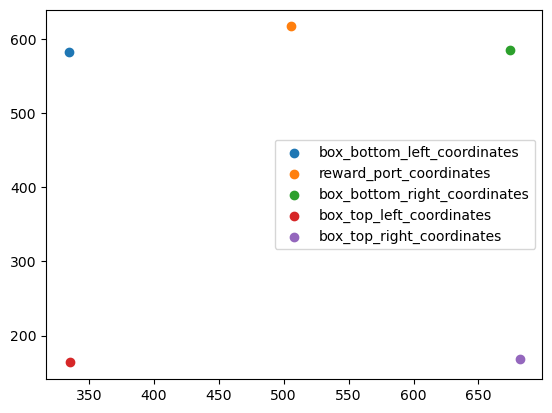

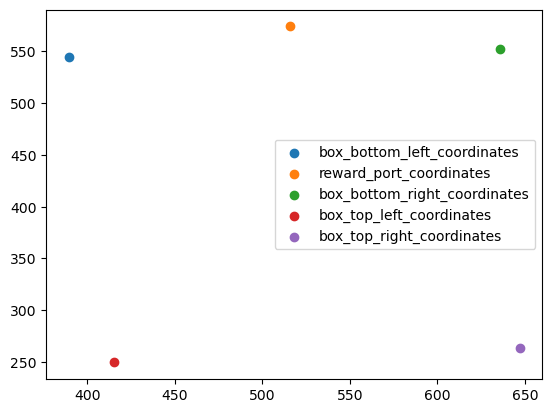

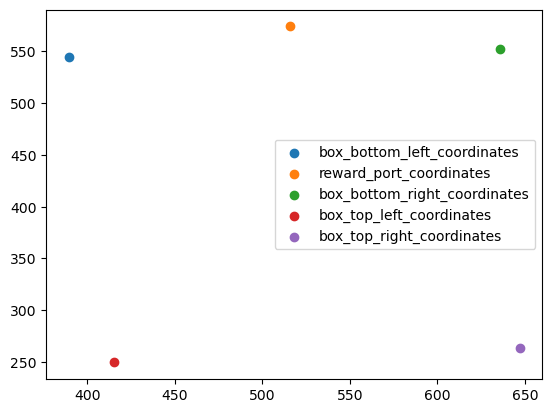

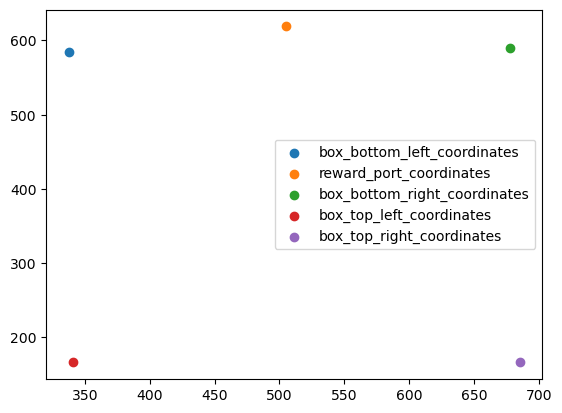

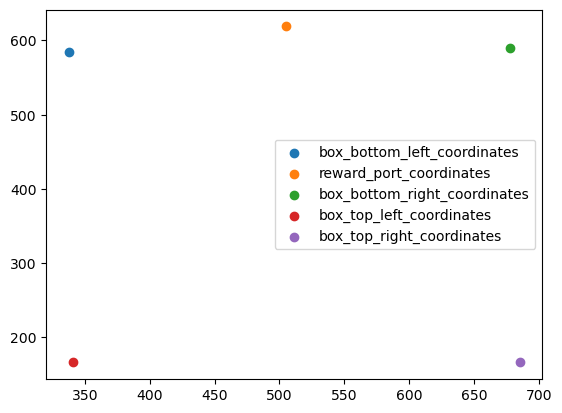

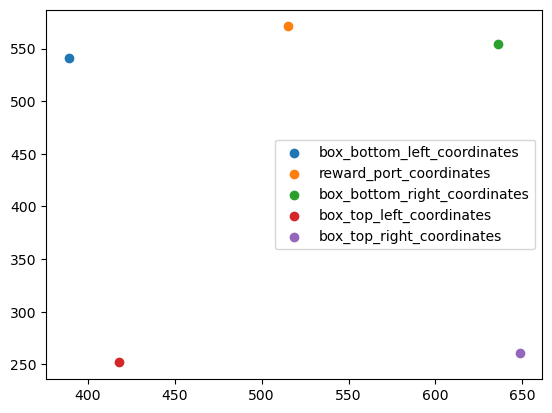

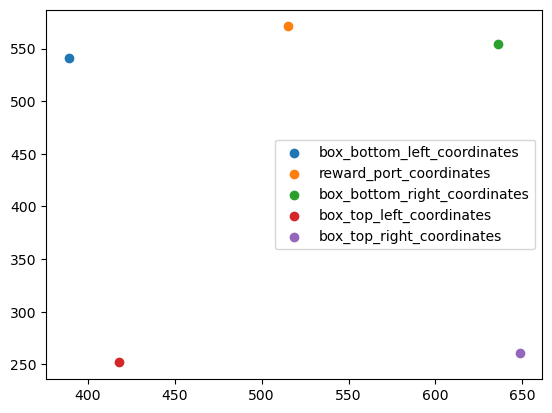

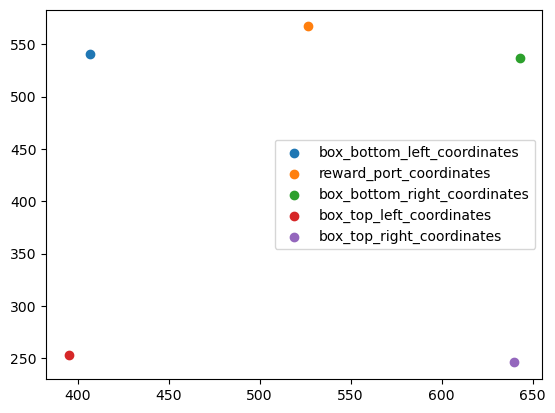

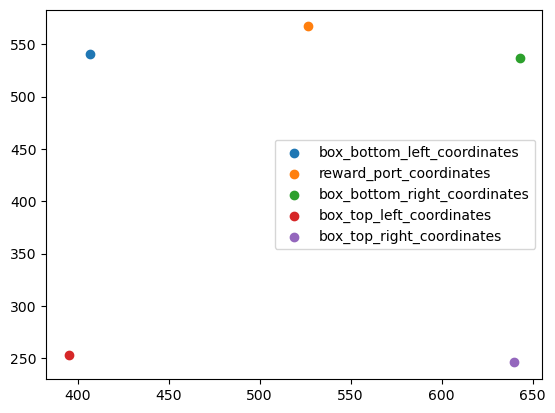

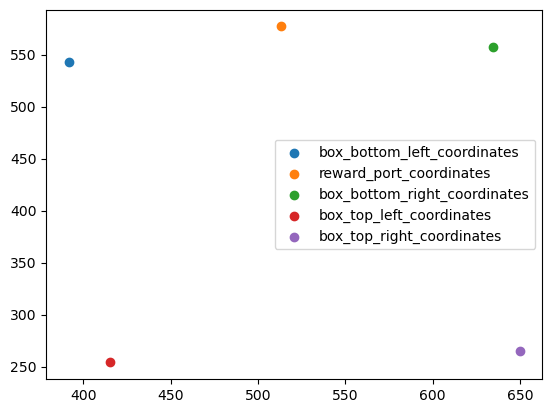

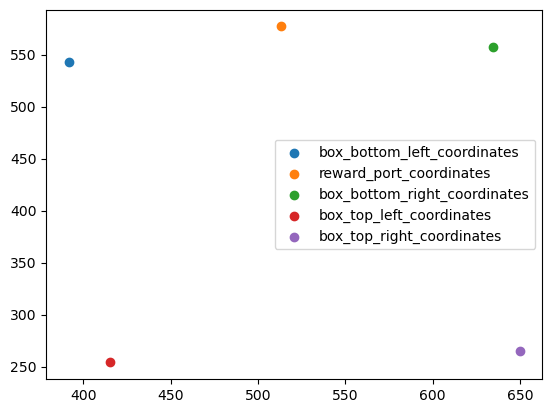

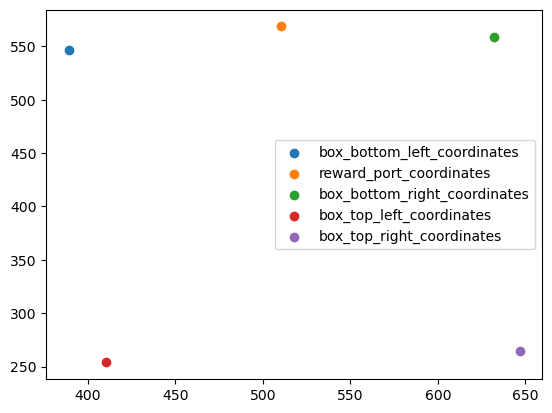

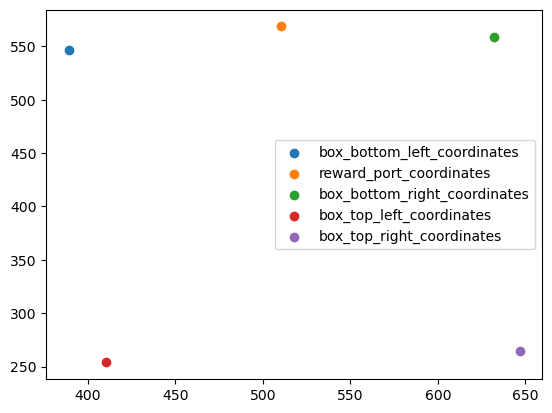

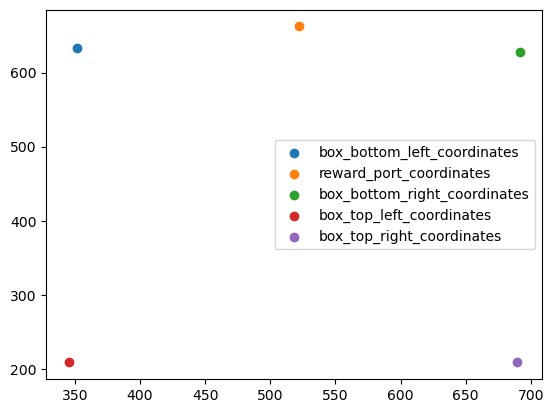

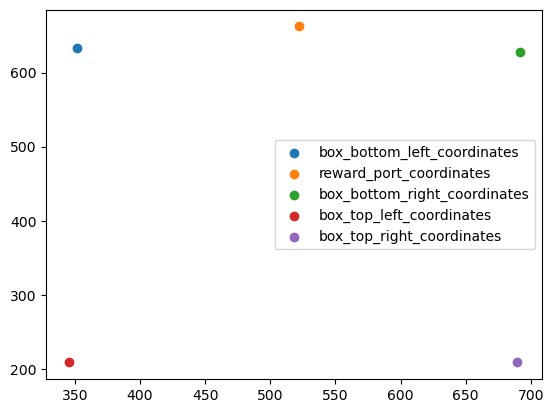

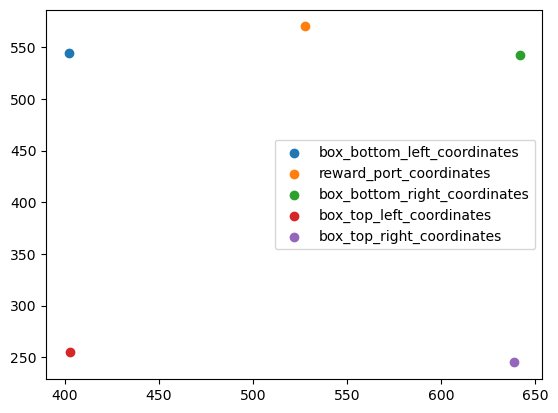

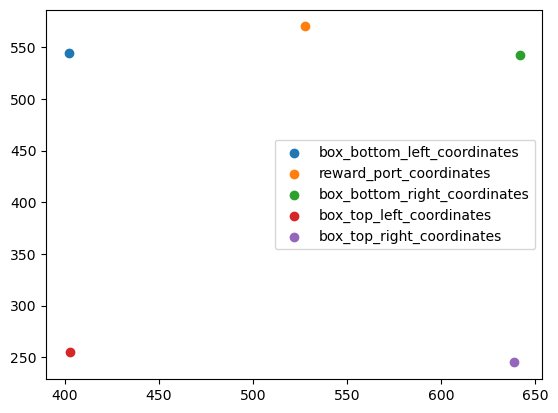

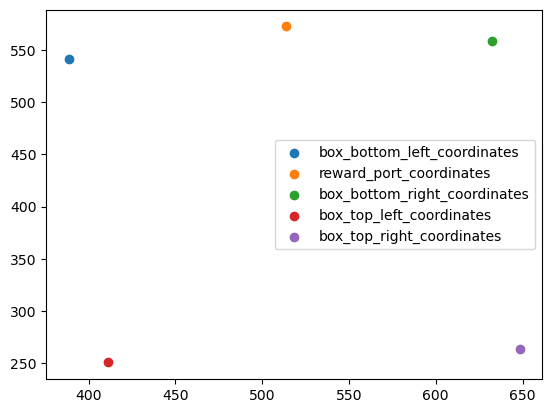

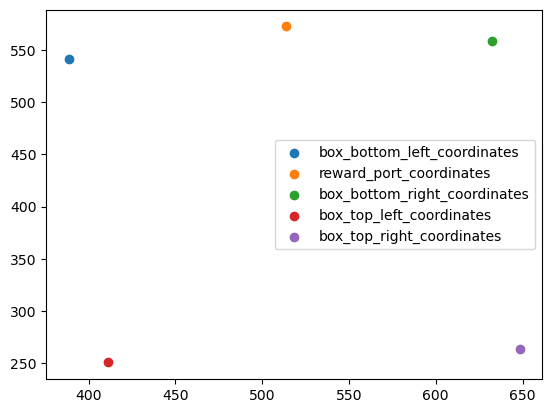

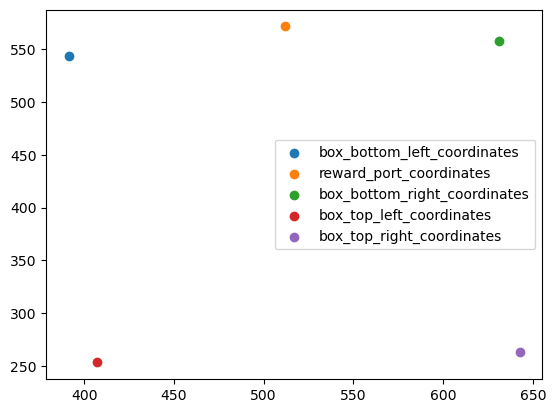

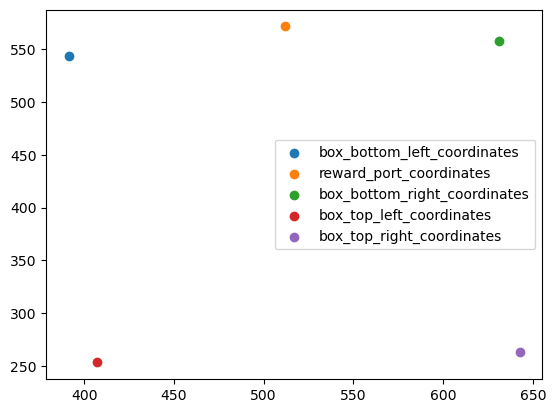

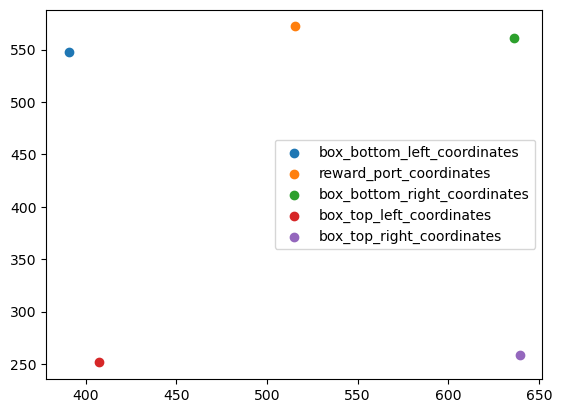

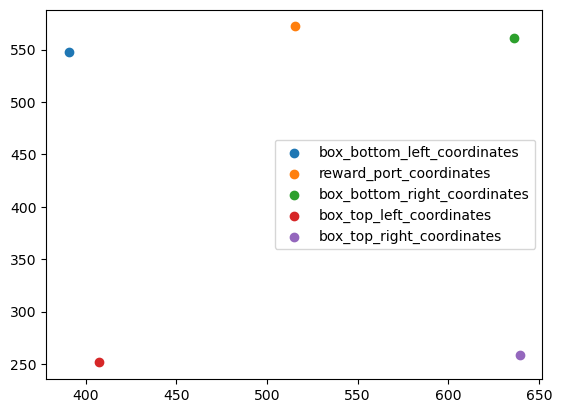

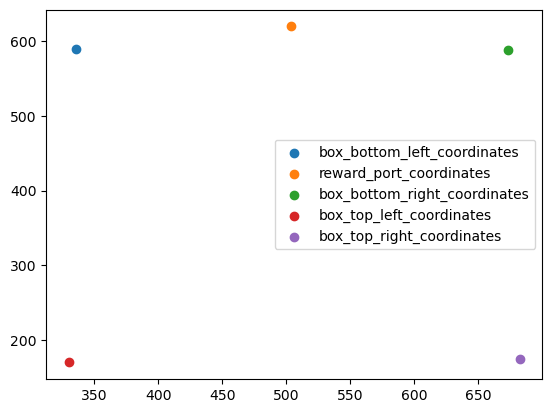

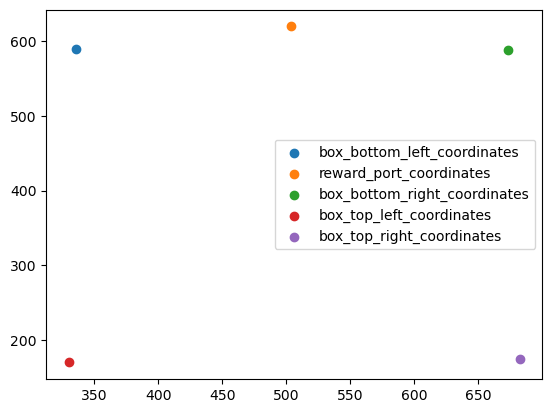

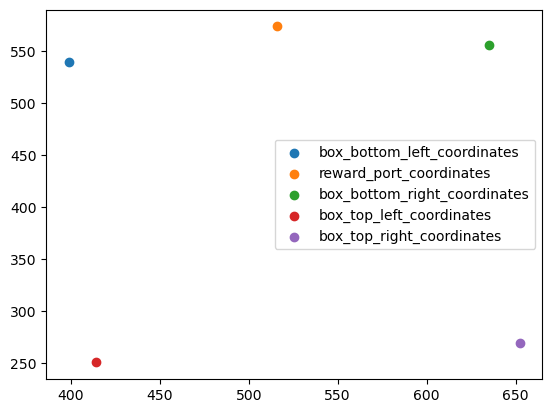

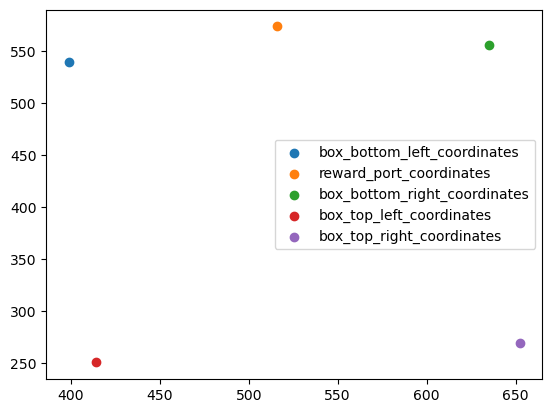

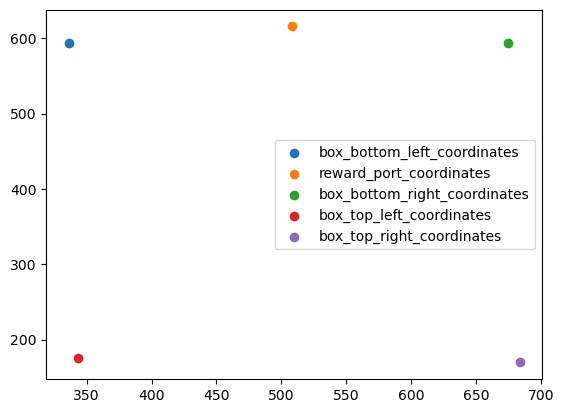

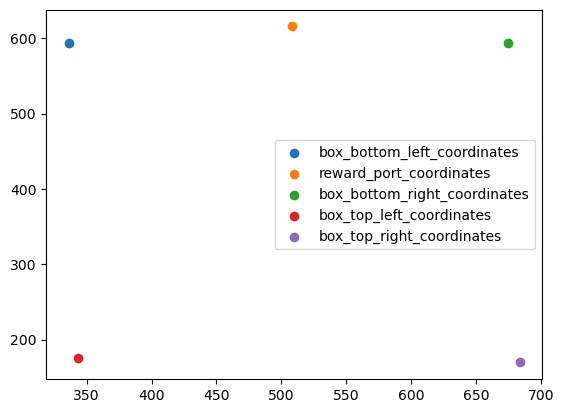

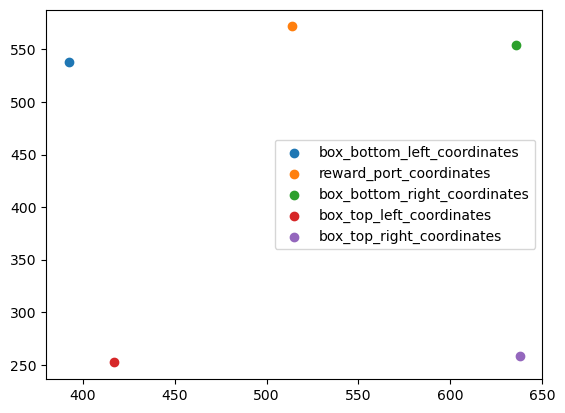

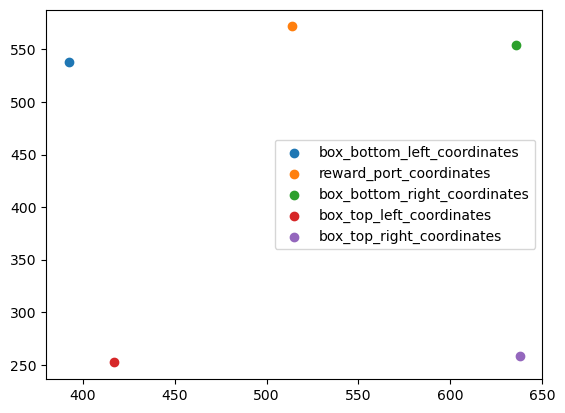

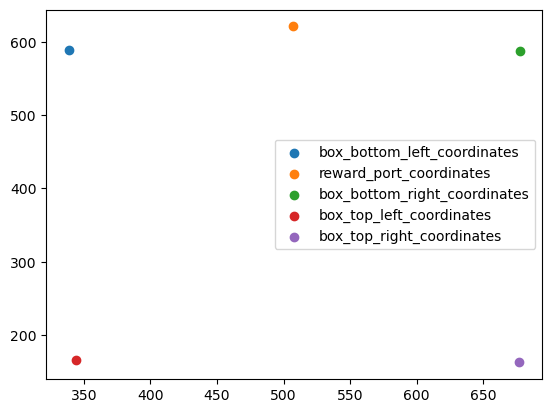

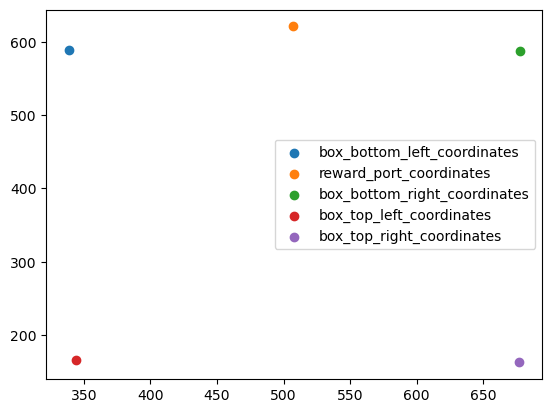

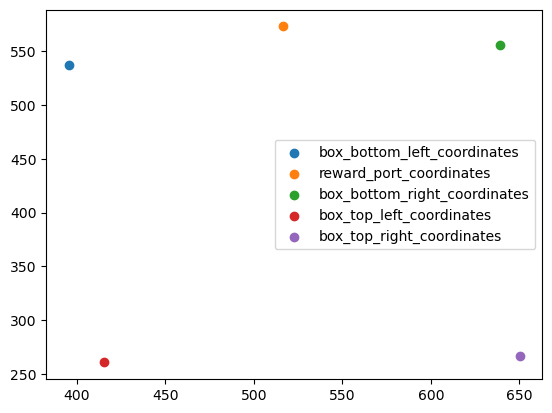

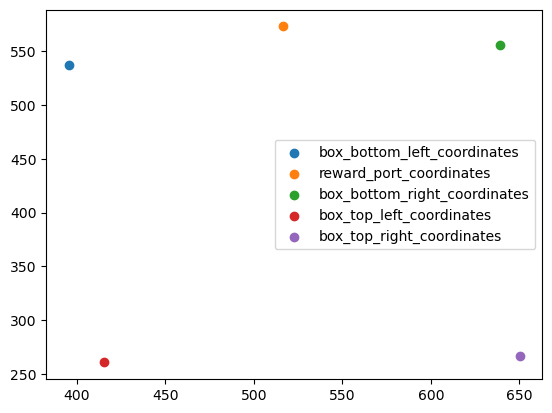

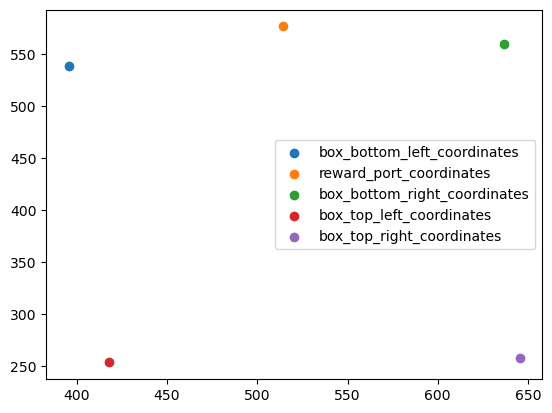

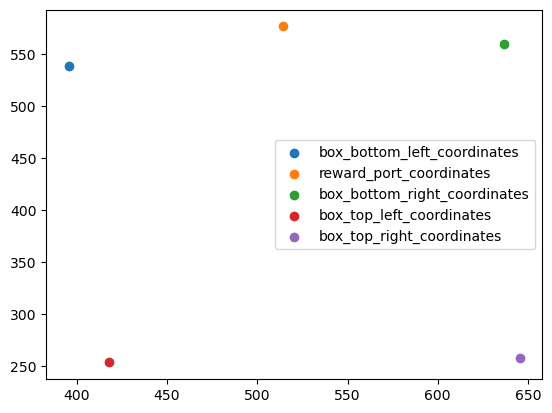

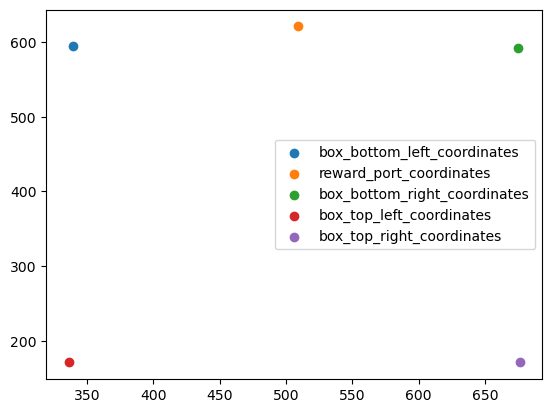

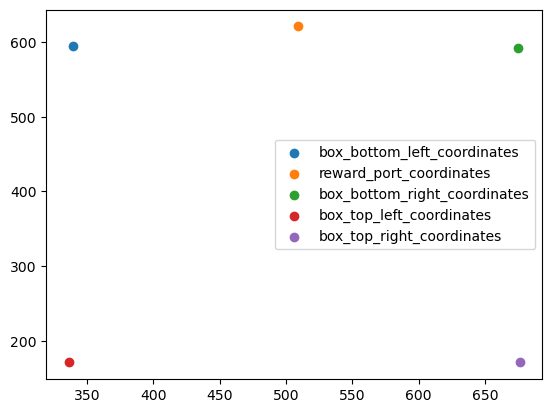

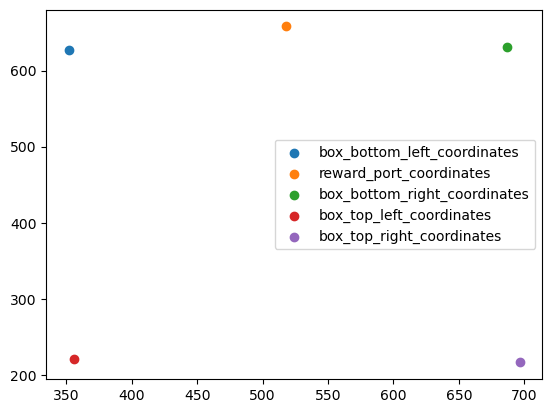

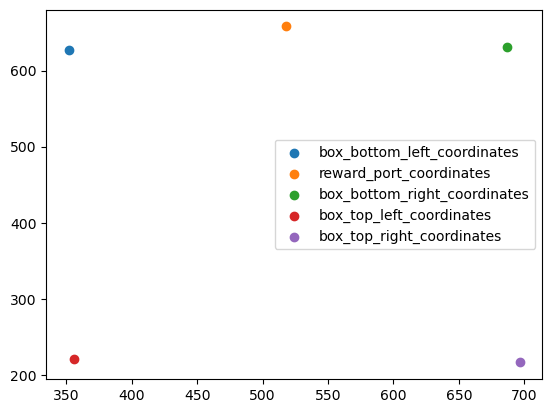

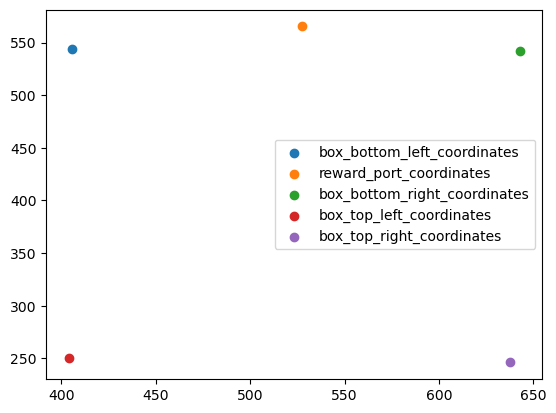

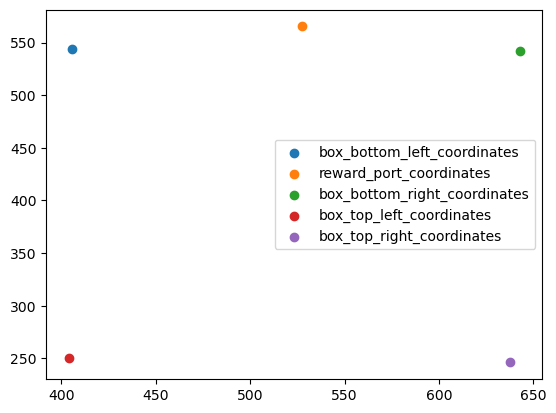

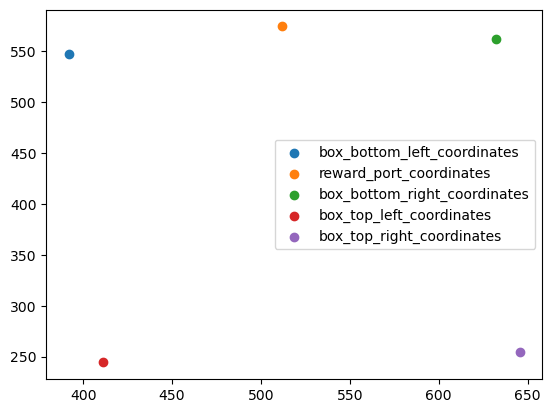

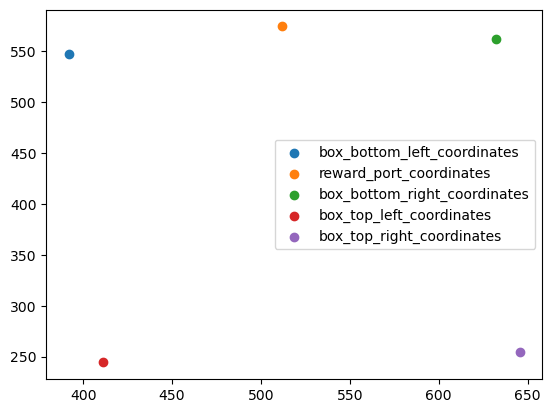

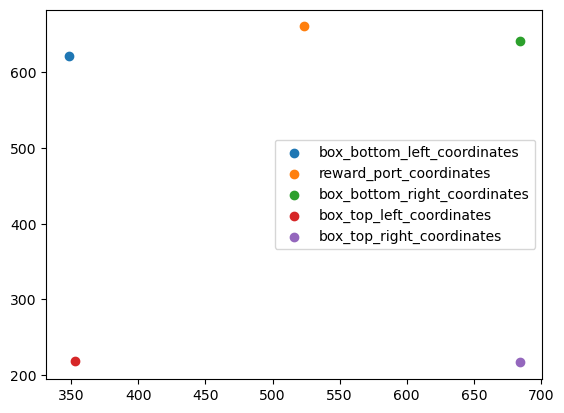

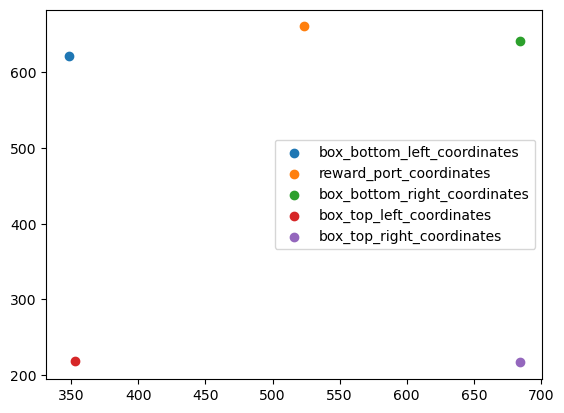

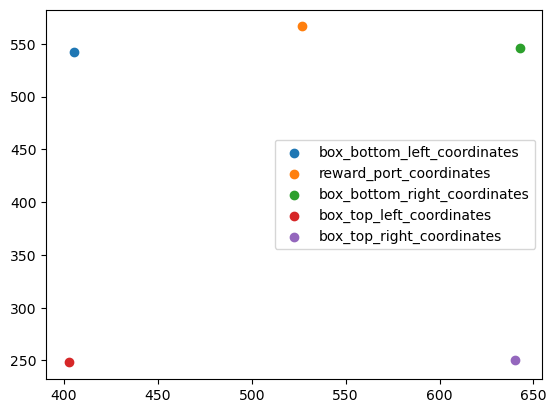

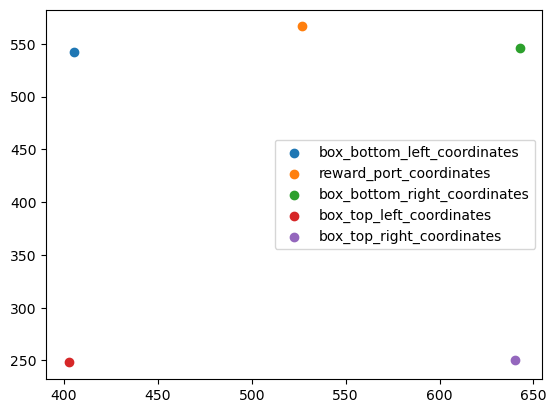

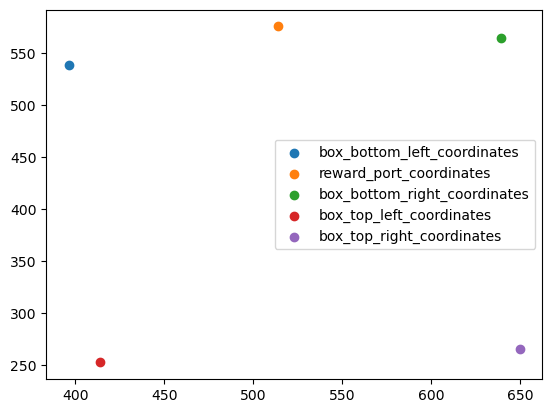

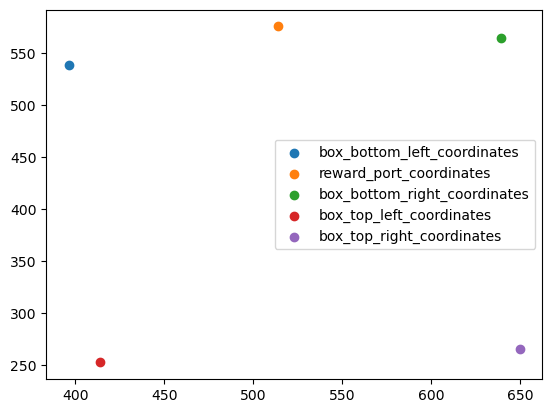

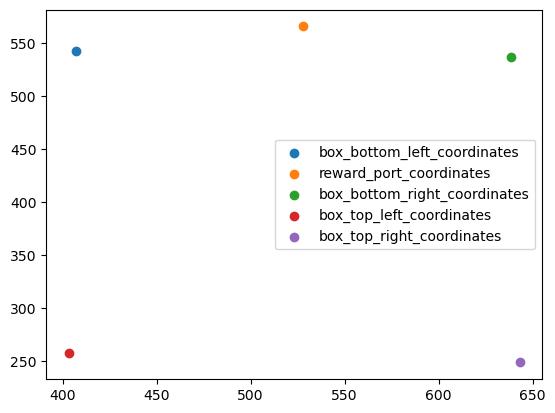

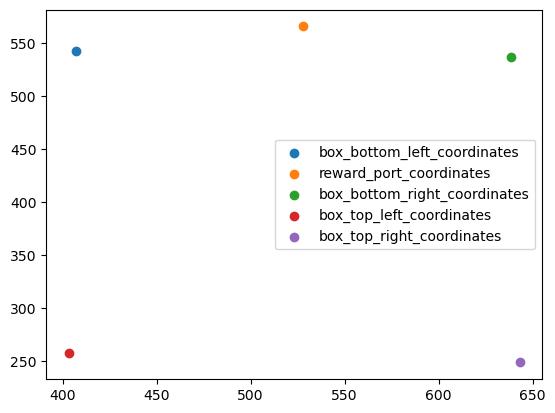

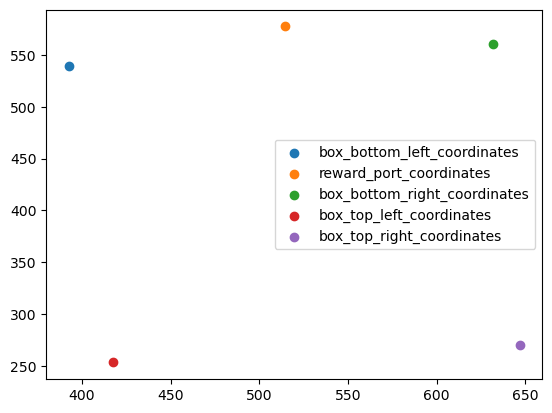

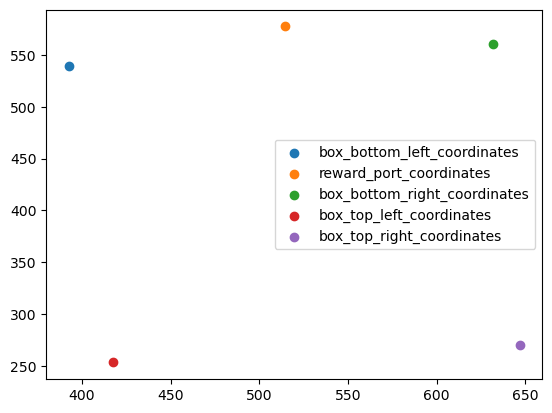

In [68]:
for index, row in TONE_START_DF.iterrows():
    fig, ax = plt.subplots()

    for corner in corner_columns:
        plt.scatter(row[corner][0], row[corner][1], label=corner)
    plt.legend()
    plt.show()
    plt.close()

# Getting the distances between corners

- Getting the average width and height so that we can convert pixels to cm

In [69]:
TONE_START_DF["bottom_width"] = TONE_START_DF.apply(lambda row: row["box_bottom_right_coordinates"][0] - row["box_bottom_left_coordinates"][0], axis=1)
TONE_START_DF["top_width"] = TONE_START_DF.apply(lambda row: row["box_top_right_coordinates"][0] - row["box_top_left_coordinates"][0], axis=1)

In [70]:
TONE_START_DF["right_height"] = TONE_START_DF.apply(lambda row: row["box_bottom_right_coordinates"][1] - row["box_top_right_coordinates"][1], axis=1)
TONE_START_DF["left_height"] = TONE_START_DF.apply(lambda row: row["box_bottom_left_coordinates"][1] - row["box_top_left_coordinates"][1], axis=1)

In [71]:
TONE_START_DF["average_height"] = TONE_START_DF.apply(lambda row: (row["right_height"] + row["left_height"])/2, axis=1)
TONE_START_DF["average_width"] = TONE_START_DF.apply(lambda row: (row["bottom_width"] + row["top_width"])/2, axis=1)

- Getthing the cm per pixel value

In [79]:
TONE_START_DF["width_ratio"] = MEDPC_BOX_WIDTH / TONE_START_DF["average_width"]
TONE_START_DF["height_ratio"] = MEDPC_BOX_LENGTH / TONE_START_DF["average_height"]


- Scaling the reward port coordinates based on the ratios of the height and width to the actual cage

In [75]:
TONE_START_DF["reward_port_scaled"] = TONE_START_DF.apply(lambda row: np.array([row["reward_port_coordinates"][0] * row["width_ratio"], row["reward_port_coordinates"][1] * row["height_ratio"]]), axis=1)

In [77]:
TONE_START_DF["reward_port_scaled"][:5]

0      [62.65767561559346, 46.6450642268789]
0      [62.65767561559346, 46.6450642268789]
1    [44.79031206327622, 38.095121316373195]
1    [44.79031206327622, 38.095121316373195]
2     [44.42939704940567, 35.56550022490564]
Name: reward_port_scaled, dtype: object

# Getting the coordinates of each mouse

In [83]:
TONE_START_DF["pose_estimation_sleap"] = TONE_START_DF["pose_estimation_file"].apply(lambda x: extract_sleap_data_from_h5(x))

- Getting the track names of all the animals from SLEAP

In [86]:
TONE_START_DF["track_names"] = TONE_START_DF["pose_estimation_sleap"].apply(lambda x: x[2])

- Getting the ID of that track name from the track names list

In [89]:
TONE_START_DF["track_id"] = TONE_START_DF.apply(lambda x: x["track_names"].index(str(x["subj_id"]).strip()), axis=1)

In [92]:
TONE_START_DF["track_id"].head()

0    0
0    1
1    0
1    1
2    0
Name: track_id, dtype: int64

- Getting the track based on the ID

In [93]:
TONE_START_DF["subj_track"] = TONE_START_DF.apply(lambda x: x["pose_estimation_sleap"][0][:,:,:,x["track_id"]], axis=1)

- Interpolating missing coordinates

In [95]:
TONE_START_DF["pose_estimation_original_coordinates"] = TONE_START_DF.apply(lambda x: interpolate_missing_coords(x["subj_track"]), axis=1)


- Scaling coordinates

In [98]:
TONE_START_DF["pose_estimation_scaled_coordinates"] = TONE_START_DF.apply(lambda row: scale_sleap_coordinates(row, "pose_estimation_original_coordinates"), axis=1)     


- Getting the coordinates for specific body parts

In [100]:
TONE_START_DF["pose_estimation_sleap"].iloc[0][1]

['left_ear', 'right_ear', 'nose', 'tail_base', 'thorax', 'forehead']

In [103]:
thorax_index = TONE_START_DF["pose_estimation_sleap"].iloc[0][1].index("thorax")

In [102]:
nose_index = TONE_START_DF["pose_estimation_sleap"].iloc[0][1].index("nose")

In [106]:
TONE_START_DF["pose_estimation_thorax_coordinates"] = TONE_START_DF["pose_estimation_scaled_coordinates"].apply(lambda x: x[:,thorax_index,:])
TONE_START_DF["pose_estimation_nose_coordinates"] = TONE_START_DF["pose_estimation_scaled_coordinates"].apply(lambda x: x[:,nose_index,:])



In [107]:
TONE_START_DF.head()

,File Name,Frame Start,FPS,Strain,file_base,date,all_subj,subj_id,subj_index,all_tone_frame,...,height_ratio,reward_port_scaled,pose_estimation_sleap,track_names,track_id,subj_track,pose_estimation_original_coordinates,pose_estimation_scaled_coordinates,pose_estimation_thorax_coordinates,pose_estimation_nose_coordinates
0,10-03-22_Test_1_1-1v1-2,2135,30,C57,10-03-22_Test_1_1-1v1-2,2022-10-03,"(1.1, 1.2)",1.1,0,"[2135, 4535, 7235, 9635, 11885, 14885, 17735, ...",...,0.081602,"[62.65767561559346, 46.6450642268789]","([[[[nan nan]\n [nan nan]], [[nan nan]\n [nan ...","[1.1, 1.2]",0,"[[[nan, nan], [nan, nan], [nan, nan], [nan, na...","[[[520.4361572265625, 564.3905639648438], [499...","[[[63.45613955133118, 46.055351719549506], [60...","[[64.2990287199225, 44.027829978141874], [64.2...","[[61.95142736975598, 47.024957207474664], [61...."
0,10-03-22_Test_1_1-1v1-2,2135,30,C57,10-03-22_Test_1_1-1v1-2,2022-10-03,"(1.1, 1.2)",1.2,1,"[2135, 4535, 7235, 9635, 11885, 14885, 17735, ...",...,0.081602,"[62.65767561559346, 46.6450642268789]","([[[[nan nan]\n [nan nan]], [[nan nan]\n [nan ...","[1.1, 1.2]",1,"[[[nan, nan], [nan, nan], [nan, nan], [nan, na...","[[[368.9432067871094, 284.2481384277344], [392...","[[[44.98479072084644, 23.195192880177135], [47...","[[47.306155506552955, 24.141277551998048], [47...","[[45.88192047944392, 22.883719500162446], [45...."
1,10-03-22_Test_2_1-3v1-4,2123,29,C57,10-03-22_Test_2_1-3v1-4,2022-10-03,"(1.3, 1.4)",1.3,0,"[2123, 4523, 7223, 9623, 11873, 14873, 17723, ...",...,0.057763,"[44.79031206327622, 38.095121316373195]","([[[[nan nan]\n [nan nan]], [[nan nan]\n [nan ...","[1.3, 1.4]",0,"[[[nan, nan], [nan, nan], [nan, nan], [nan, na...","[[[680.289306640625, 400.05560302734375], [676...","[[[58.644644060289274, 23.108399542698006], [5...","[[61.7094413419158, 22.198077497602327], [61.7...","[[56.56298560120289, 22.455181588334806], [56...."
1,10-03-22_Test_2_1-3v1-4,2123,29,C57,10-03-22_Test_2_1-3v1-4,2022-10-03,"(1.3, 1.4)",1.4,1,"[2123, 4523, 7223, 9623, 11873, 14873, 17723, ...",...,0.057763,"[44.79031206327622, 38.095121316373195]","([[[[nan nan]\n [nan nan]], [[nan nan]\n [nan ...","[1.3, 1.4]",1,"[[[nan, nan], [nan, nan], [nan, nan], [nan, na...","[[[531.3592529296875, 648.0527954101562], [499...","[[[45.80606214447569, 37.43345376936677], [43....","[[46.209723992701065, 34.683338490517976], [46...","[[44.43057909562303, 38.370441477231374], [44...."
2,10-03-22_Test_3_2-1v2-2,2125,29,C57,10-03-22_Test_3_2-1v2-2,2022-10-03,"(2.1, 2.2)",2.1,0,"[2125, 4525, 7225, 9625, 11875, 14875, 17725, ...",...,0.057216,"[44.42939704940567, 35.56550022490564]","([[[[nan nan]\n [nan nan]], [[nan nan]\n [nan ...","[2.1, 2.2]",0,"[[[nan, nan], [nan, nan], [nan, nan], [nan, na...","[[[315.74310302734375, 508.35687255859375], [3...","[[[27.565068021130507, 29.086254855981128], [2...","[[30.34017396475596, 30.427972245799346], [30....","[[27.245267225786062, 27.659397618676238], [27..."


# Calculating the distance from thorax to reward port

In [108]:
TONE_START_DF["thorax_to_reward_port_distance"] = TONE_START_DF.apply(lambda row: np.linalg.norm(row["pose_estimation_thorax_coordinates"] - row["reward_port_scaled"], axis=1), axis=1)



In [268]:
TONE_START_DF["thorax_to_reward_port_tone_slices"] = TONE_START_DF.apply(lambda row:  np.vstack([row["thorax_to_reward_port_distance"][tone_frame-frame_range:tone_frame+frame_range] for tone_frame in row["all_tone_frame"] if tone_frame <= row["thorax_to_reward_port_distance"].shape[0]]), axis=1)


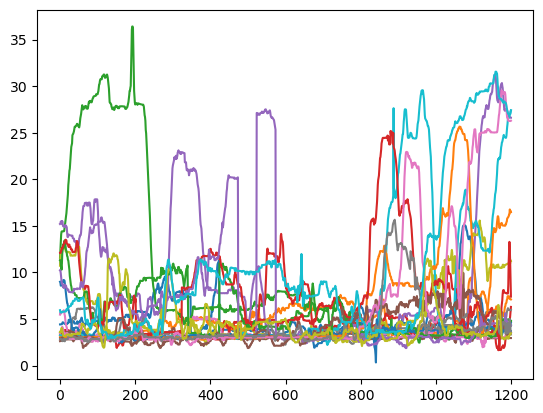

In [281]:
# Iterate over each row in the array
for i, row in enumerate(TONE_START_DF["thorax_to_reward_port_tone_slices"].iloc[10]):
    # Plot the row data
    plt.plot(row, label=f'Line {i+1}')



In [282]:
i

19

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a4490980-3f6a-4f44-80eb-ebd789a5b21f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>